## Jobs

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score # to split the data into train and test datasets 
from sklearn.preprocessing import StandardScaler # use of StandardScaler to standarise the dataset
import numpy as np # library of mathematical operations
import pandas as pd  # for data anlysis and manipulation
import matplotlib.pyplot as plt # to display charts
import seaborn as sns # datisualisation library
from sklearn.model_selection import GridSearchCV # library function for cross-validation
from econml.metalearners import XLearner # advanced CATE estimator
from sklearn.ensemble import RandomForestClassifier # meta estimator for fitting decision trees
from sklearn.tree import DecisionTreeClassifier # tree-structed classifier used for model building

from helper_functions import feat_imp, get_ps_weights, policy_risk # self-defined funtions 

### Loading the dataset

In [4]:
# to load the dataset
jobs = pd.read_csv("https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.csv", delimiter=",")
jobs

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,t,y,e
0,-0.614282,1.464727,0.0,0.0,1.0,0.0,2.393250,2.746196,-0.653311,-0.656913,1.627531,2.462337,2.937244,0.0,0.0,2.843909,0.0,0.0,1.0,0.0
1,-0.802463,0.101835,0.0,0.0,1.0,0.0,0.109885,0.498271,-0.785284,-0.743407,-0.022502,-0.177193,0.082537,0.0,0.0,0.038422,0.0,0.0,1.0,0.0
2,-0.896553,-0.238888,1.0,0.0,1.0,1.0,-0.085212,-0.148097,-0.847312,-0.781606,-0.361348,-0.286221,-0.303615,0.0,0.0,-0.191304,0.0,0.0,1.0,0.0
3,-0.896553,-0.238888,0.0,0.0,0.0,1.0,0.405581,0.325594,-0.847312,-0.781606,-0.361348,0.023020,-0.039630,0.0,0.0,0.173108,0.0,0.0,1.0,1.0
4,0.138440,-1.601779,1.0,0.0,1.0,1.0,-0.722531,-0.212734,-0.019840,-0.156019,-1.422084,-0.514563,-0.331552,0.0,0.0,-0.779227,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3207,1.737976,1.805449,0.0,0.0,1.0,0.0,4.235839,-1.110467,1.887171,1.995900,2.113702,6.424008,-0.518815,0.0,1.0,5.197260,0.0,0.0,0.0,0.0
3208,-0.520192,0.101835,0.0,0.0,0.0,0.0,0.239950,0.289997,-0.583365,-0.608340,-0.022502,-0.094318,-0.063091,0.0,0.0,0.143774,0.0,0.0,1.0,0.0
3209,-0.802463,0.442558,1.0,0.0,0.0,0.0,0.124337,0.692182,-0.785284,-0.743407,0.345809,-0.168387,0.236242,0.0,0.0,0.135970,0.0,0.0,1.0,0.0
3210,0.702982,0.101835,0.0,0.0,1.0,0.0,0.341112,0.670636,0.566120,0.413295,-0.022502,-0.024223,0.218301,0.0,0.0,0.225715,0.0,0.0,1.0,0.0


### Exploring the dataset

In [5]:
# to print information about the dataset
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      3212 non-null   float64
 1   x2      3212 non-null   float64
 2   x3      3212 non-null   float64
 3   x4      3212 non-null   float64
 4   x5      3212 non-null   float64
 5   x6      3212 non-null   float64
 6   x7      3212 non-null   float64
 7   x8      3212 non-null   float64
 8   x9      3212 non-null   float64
 9   x10     3212 non-null   float64
 10  x11     3212 non-null   float64
 11  x12     3212 non-null   float64
 12  x13     3212 non-null   float64
 13  x14     3212 non-null   float64
 14  x15     3212 non-null   float64
 15  x16     3212 non-null   float64
 16  x17     3212 non-null   float64
 17  t       3212 non-null   float64
 18  y       3212 non-null   float64
 19  e       3212 non-null   float64
dtypes: float64(20)
memory usage: 502.0 KB


In [6]:
jobs['y'].value_counts(1)

1.0    0.849938
0.0    0.150062
Name: y, dtype: float64

In [7]:
jobs['t'].value_counts(1)

0.0    0.907534
1.0    0.092466
Name: t, dtype: float64

In [8]:
nrow, ncol = jobs.shape
print(f'There are {nrow} rows and {ncol} columns')

There are 3212 rows and 20 columns


In [9]:
x = jobs[["x1", 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
         'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17']]

In [10]:
# reshaping the single dimension vectors into 2D vectors as some methods prefer this representaion of data
T = jobs['t'].values.reshape(-1, 1)
Y = jobs['y'].values.reshape(-1, 1)
e = jobs['e']

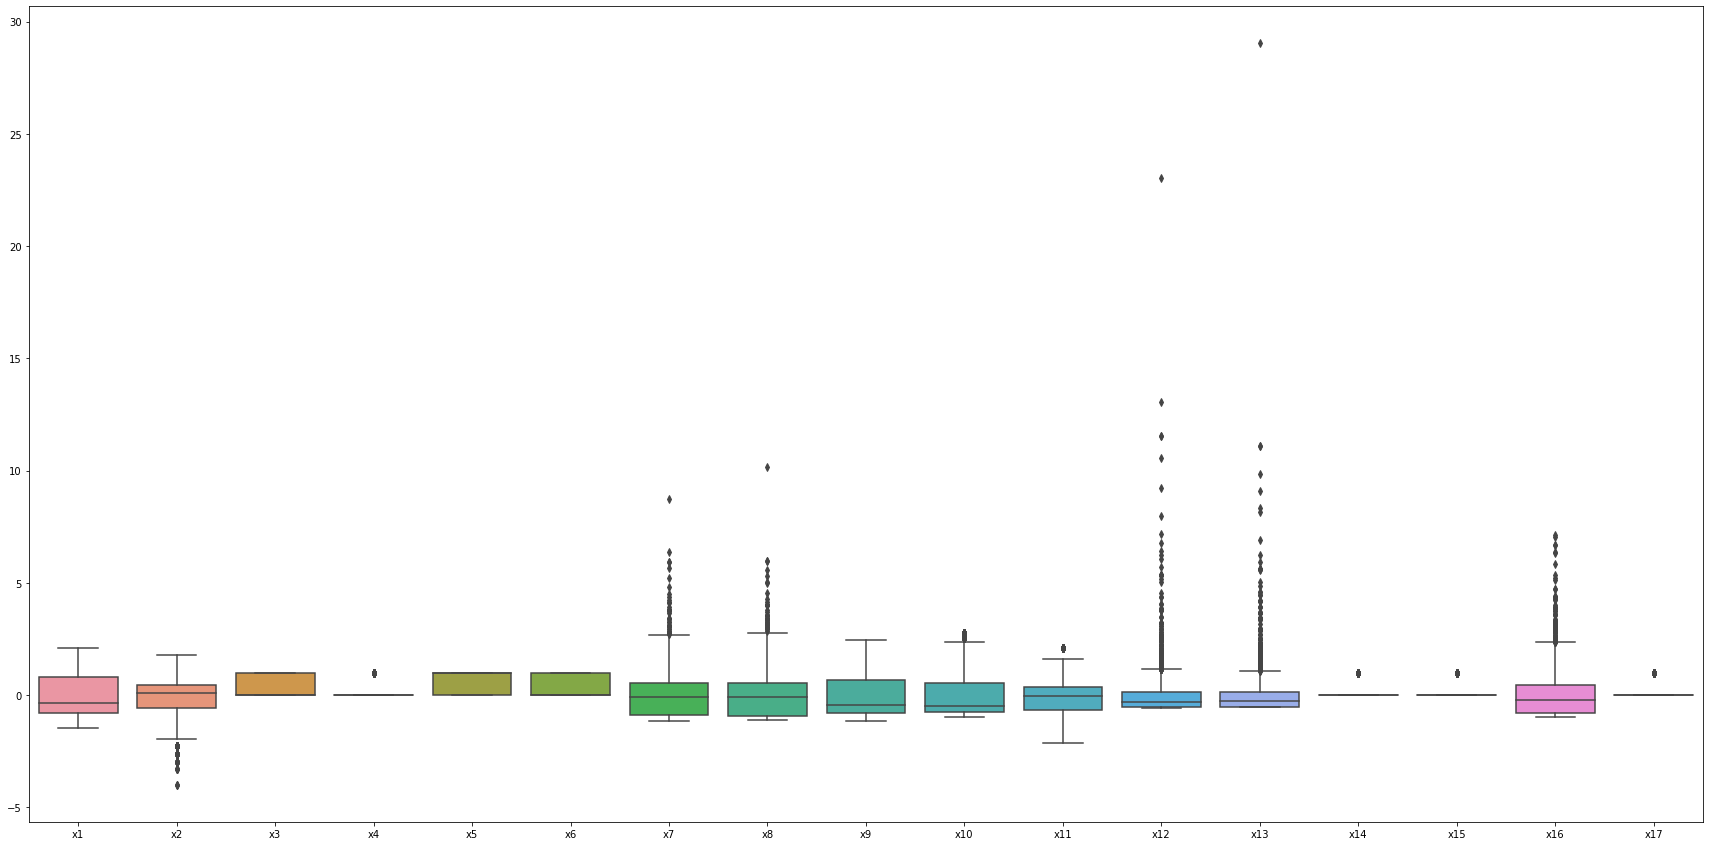

In [11]:
# to plot a boxplot of each feature in the dataset and check if the features vary in scale
plt.figure(figsize=(30,15))
_ = sns.boxplot(data = x)

In [ ]:
plt.savefig("jobs_boxplot.pdf")

array([[<AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x2'}>,
        <AxesSubplot:title={'center':'x3'}>,
        <AxesSubplot:title={'center':'x4'}>],
       [<AxesSubplot:title={'center':'x5'}>,
        <AxesSubplot:title={'center':'x6'}>,
        <AxesSubplot:title={'center':'x7'}>,
        <AxesSubplot:title={'center':'x8'}>],
       [<AxesSubplot:title={'center':'x9'}>,
        <AxesSubplot:title={'center':'x10'}>,
        <AxesSubplot:title={'center':'x11'}>,
        <AxesSubplot:title={'center':'x12'}>],
       [<AxesSubplot:title={'center':'x13'}>,
        <AxesSubplot:title={'center':'x14'}>,
        <AxesSubplot:title={'center':'x15'}>,
        <AxesSubplot:title={'center':'x16'}>],
       [<AxesSubplot:title={'center':'x17'}>,
        <AxesSubplot:title={'center':'t'}>,
        <AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'e'}>]], dtype=object)

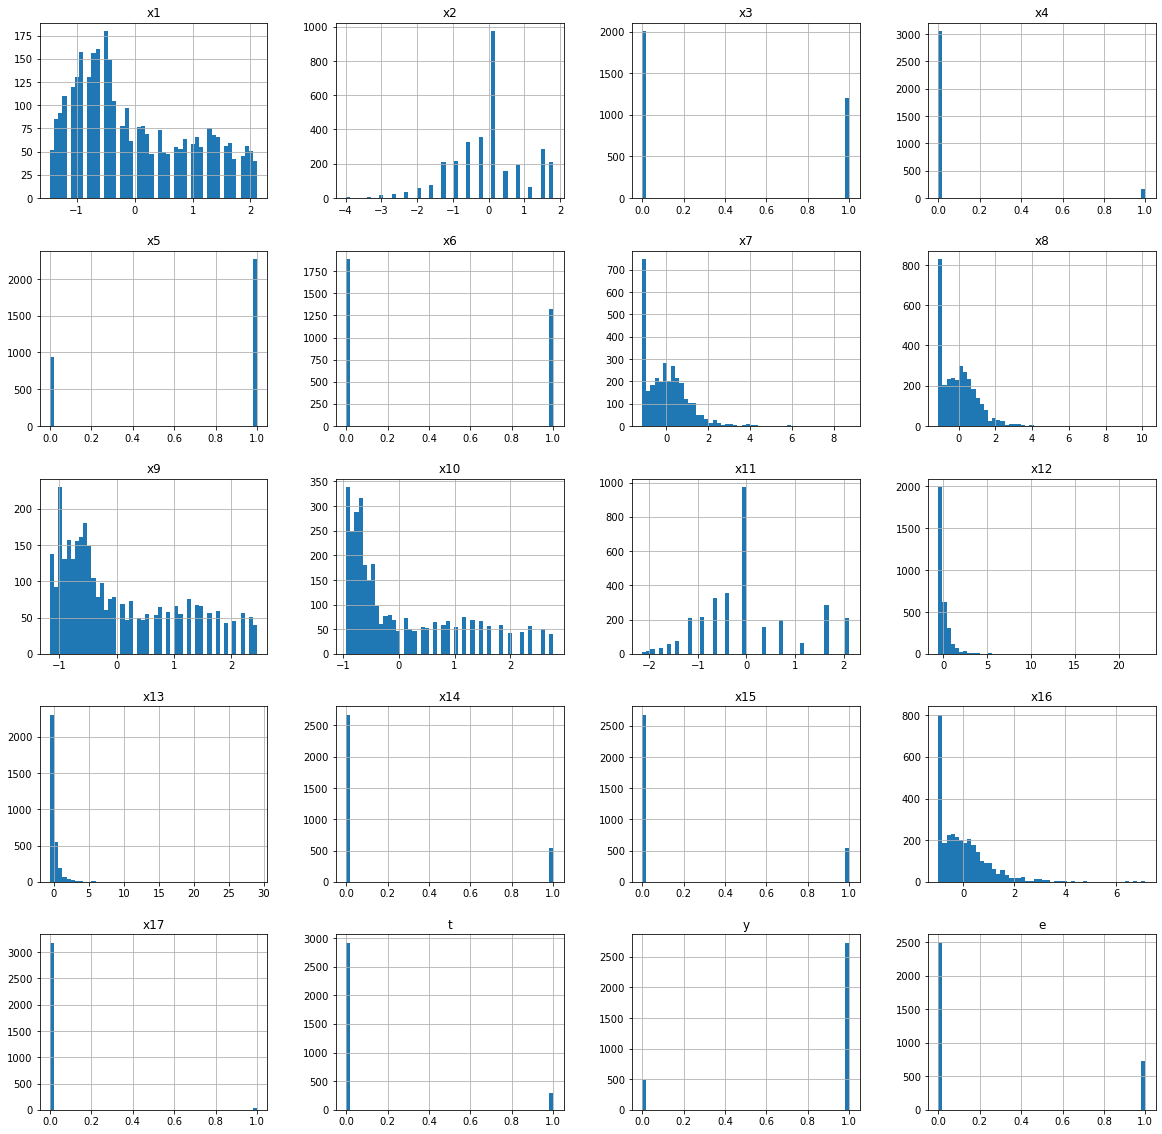

In [12]:
# to draw histogram and look at the distribution of values of each feature
jobs.hist(bins=50, figsize=(20,20))

In [ ]:
plt.savefig("jobs_histogram.pdf")

<AxesSubplot:xlabel='y', ylabel='count'>

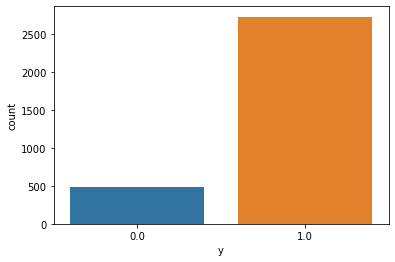

In [13]:
sns.countplot(x = "y", data = jobs)

In [ ]:
plt.savefig("jobs_y.pdf")

<AxesSubplot:xlabel='t', ylabel='count'>

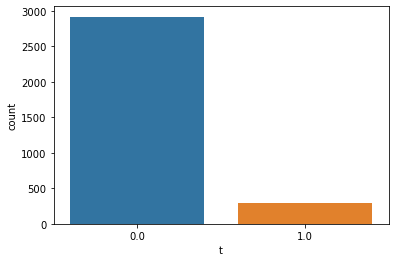

In [14]:
sns.countplot(x = "t", data = jobs)

In [ ]:
plt.savefig("jobs_t.pdf")

<AxesSubplot:>

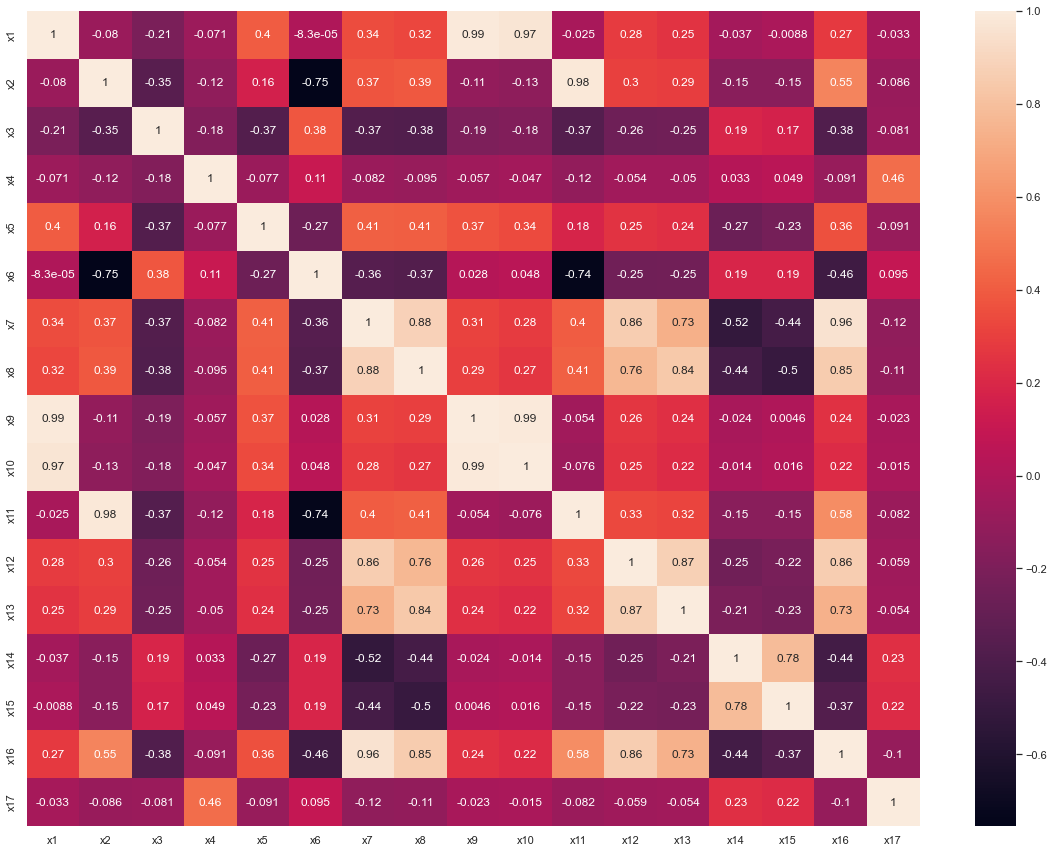

In [15]:
# to calculate the correlations between each pair of variables
corr = x.corr()

# to plot a heatmap of the correlations between pairs of features
sns.set(rc = {'figure.figsize':(20,15)})
sns.heatmap(corr, annot = True)

In [ ]:
plt.savefig("jobs_heatmap.pdf")

### Data Pre-Processing

In [16]:
# to split the data into train and test datasets
train_set, test_set = train_test_split(jobs, test_size=0.2, random_state=50)  
print(len(train_set), len(test_set))

2569 643


In [17]:
x_train = train_set.drop(['t', 'y', 'e'], axis = 1)
x_test = test_set.drop(['t', 'y', 'e'], axis = 1)

In [18]:
y_train = train_set['y']
y_test = test_set['y']

In [19]:
t_train = train_set['t']
t_test = test_set['t']

In [20]:
e_train = train_set['e']
e_test = test_set['e']

In [21]:
# to standarise the dataset i.e. mean = 0 and s.d. = 1
scaler_x = StandardScaler() 
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

In [22]:
xtrain = pd.DataFrame(x_train)
ttrain = pd.DataFrame(t_train)

In [23]:
xtest = pd.DataFrame(x_test)
ttest = pd.DataFrame(t_test)

## Modelling

#### Simple learners

In [24]:
# to fit a simple Random Forest classification model
clf = RandomForestClassifier()

In [25]:
scores = cross_val_score(clf, x_train, y_train, cv=10, scoring = "f1")
print("f1 score: %.2f +/- %.2f" % (scores.mean(), scores.std()))

f1 score: 0.92 +/- 0.01


In [26]:
param_grid = { 
    'n_estimators': [25,50,100,150],
    'max_depth' : [3,4,5,6,7,8],
}

In [27]:
# for hyperparameter tuning
CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 10)
CV_clf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [25, 50, 100, 150]})

In [28]:
# to find the best suited parameters for the classification model
CV_clf.best_params_

{'max_depth': 6, 'n_estimators': 50}

In [29]:
simple_clf = RandomForestClassifier(n_estimators = 100, max_depth = 4)

In [30]:
xt_train = np.concatenate([xtrain, ttrain], axis=1)

# to build the model on the traing data
simple_clf.fit(xt_train, y_train)

RandomForestClassifier(max_depth=4)

In [31]:
scores = cross_val_score(simple_clf, xt_train, y_train, cv = 10, scoring = "f1")
print("f1 score: %.2f +/- %.2f" % (scores.mean(), scores.std()))

f1 score: 0.93 +/- 0.01


In [32]:
# to merge x and t = 1
xt1_test = np.concatenate([xtest, np.ones_like(ttest)], axis=1)

# to predict y based on features and treatmnent effects
simple_clf_y1_test = simple_clf.predict(xt1_test)

In [33]:
# to use pre-defined policy risk function
policy_risk1 = policy_risk(simple_clf_y1_test, y_test, t_test, e_test)

In [34]:
results = []
results.append(['Simple Learner', policy_risk1])

cols = ['Method', 'Policy risk']

df = pd.DataFrame(results, columns=cols)
df

,Method,Policy risk
0,Simple Learner,0.217418


In [35]:
# to plot feature importance by calling pre-defined function
importances, indices = feat_imp(simple_clf)

In [36]:
names = jobs.drop(['y', 'e'], axis=1).columns.values

In [37]:
# to print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, indices[f],  importances[indices[f]]))

Feature ranking:
1. 7 (0.214728)
2. 12 (0.166213)
3. 11 (0.112956)
4. 6 (0.094513)
5. 15 (0.092326)
6. 14 (0.074766)
7. 0 (0.056139)
8. 9 (0.048559)
9. 8 (0.047643)
10. 4 (0.027145)
11. 17 (0.018667)
12. 1 (0.012888)
13. 10 (0.009846)
14. 13 (0.009051)
15. 2 (0.008074)
16. 5 (0.003799)
17. 3 (0.002350)


<BarContainer object of 18 artists>

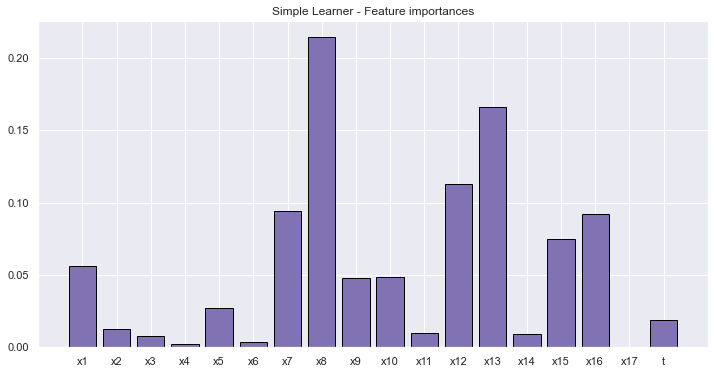

In [38]:
# to plot the feature importances of the forest
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Simple Learner - Feature importances")
plt.bar(names,importances, color="m", edgecolor="black")

#### Propensity score re-weighting

In [39]:
# to train a classifier to predict propensity scores
prop_clf = DecisionTreeClassifier()

In [40]:
scores = cross_val_score(prop_clf, x_train, t_train, cv=10, scoring = "f1")
print("f1 score: %.2f" % (scores.mean()))

f1 score: 0.32


In [41]:
param_grid = { 
    'max_depth' : [2, 3, 4, 5, 6],
}

In [42]:
# for hyperparameter tuning
CV1_model = GridSearchCV(estimator=prop_clf, param_grid=param_grid, cv= 10)
CV1_model.fit(x_train, t_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6]})

In [43]:
# to find the best suited parameters for the classification model
CV1_model.best_params_

{'max_depth': 2}

In [44]:
prop = DecisionTreeClassifier(max_depth = 2)

In [45]:
scores = cross_val_score(prop, x_train, t_train, cv=10, scoring = "f1")
print("f1 score: %.2f" % (scores.mean()))

f1 score: 0.00


In [46]:
# to get the sample weights
weights = get_ps_weights(prop, x_train, t_train)

In [47]:
# to build a Random Forest classification model
model = RandomForestClassifier()

In [48]:
scores = cross_val_score(model, x_train, y_train, cv=10, scoring = "f1")
print("f1 score: %.2f +/- %.2f" % (scores.mean(), scores.std()))

f1 score: 0.92 +/- 0.01


In [49]:
param_grid_ = { 
    'n_estimators': [25, 50, 100, 150, 200],
    'max_depth' : [4, 5, 6, 7, 8, 9, 10, 11, 12]
}

In [50]:
# for hyperparameter tuning
CV_model = GridSearchCV(estimator=model, param_grid=param_grid_, cv= 10)
CV_model.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'n_estimators': [25, 50, 100, 150, 200]})

In [51]:
# to find the best suited parameters for the classification model
CV_model.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [52]:
# to train the classifier based on the propensity model
ipsw = RandomForestClassifier(n_estimators = 50, max_depth = 5)
ipsw.fit(xt_train, y_train, sample_weight= weights)

RandomForestClassifier(max_depth=5, n_estimators=50)

In [53]:
scores = cross_val_score(ipsw, x_train, y_train, cv=10, scoring = "f1")
print("f1 score: %.2f +/- %.2f" % (scores.mean(), scores.std()))

f1 score: 0.93 +/- 0.01


In [54]:
# to make predictions
ipsw_y1_test = ipsw.predict(np.concatenate([xtest, np.ones_like(ttest)], axis=1))

In [55]:
# to merge x and t = 1
xt1_test = np.concatenate([xtest, np.ones_like(ttest)], axis=1)

# to predict y based on features and treatmnent effects
ipsw_y1_test = ipsw.predict(xt1_test)

In [56]:
# to use pre-defined policy risk function
policy_risk2 = policy_risk(ipsw_y1_test, y_test, t_test, e_test)

In [57]:
results = []
results.append(['IPSW', policy_risk2])

cols = ['Method', 'Policy Risk']

df = pd.DataFrame(results, columns=cols)
df

,Method,Policy Risk
0,IPSW,0.230605


In [58]:
# to plot feature importance by calling pre-defined function
importances, indices = feat_imp(ipsw)

In [59]:
# to print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, indices[f],  importances[indices[f]]))

Feature ranking:
1. 7 (0.277140)
2. 12 (0.136883)
3. 11 (0.083813)
4. 6 (0.075426)
5. 15 (0.068438)
6. 17 (0.048939)
7. 8 (0.046479)
8. 9 (0.045253)
9. 0 (0.044204)
10. 14 (0.036219)
11. 10 (0.035771)
12. 4 (0.033396)
13. 1 (0.025669)
14. 13 (0.022943)
15. 2 (0.009997)
16. 3 (0.004704)
17. 5 (0.004252)


<BarContainer object of 18 artists>

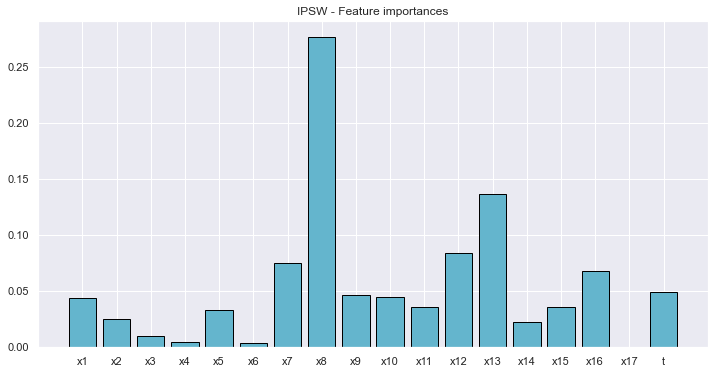

In [60]:
# to plot the feature importances of the forest
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("IPSW - Feature importances")
plt.bar(names,importances, color="c", edgecolor="black")

#### Advanced CATE estimators

In [61]:
# to implement Random Forest a cross-validation classification model that automatically chooses the hyperparameters
first_stage = GridSearchCV(
                estimator=RandomForestClassifier(),
                param_grid={
                        'max_depth': [3, 4, 5, 6, 7],
                        'n_estimators': (50, 100, 150, 200)
                    }, cv=10, n_jobs=-1, scoring='f1'
                )
mod_y = first_stage.fit(x_train, y_train).best_estimator_

In [62]:
# to implement Decision Tree Forest a cross-validation classification model that automatically chooses the hyperparameters
first_stage0 = GridSearchCV(
                estimator=DecisionTreeClassifier(),
                param_grid={
                        'max_depth': [2, 3, 4, 5, 6, 7]
                    }, cv=10, n_jobs=-1, scoring='f1'
                )
mod_t = first_stage0.fit(x_train, t_train).best_estimator_

In [63]:
# to instantiate X learner
X_learner = XLearner(models=mod_y, propensity_model=mod_t)

In [64]:
# to train X_learner
X_learner.fit(y_train, t_train, X=x_train)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [65]:
# to estimate treatment effects on test data
x_estimate = X_learner.effect(x_test)

In [66]:
# to use pre-defined policy risk function
policy_risk3 = policy_risk(x_estimate, y_test, t_test, e_test)

In [67]:
results = []
results.append(['XL', policy_risk3])

col = ['Method', 'Policy Risk']

df = pd.DataFrame(results, columns=col)
df

,Method,Policy Risk
0,XL,0.302065


#### Results comparison

In [68]:
# to compare all the results
results = []
results.append(['Simple Learner', policy_risk1])
results.append(['IPW', policy_risk2])
results.append(['XL', policy_risk3])

cols = ['Method', 'Policy Risk']

df = pd.DataFrame(results, columns=cols)
df

,Method,Policy Risk
0,Simple Learner,0.217418
1,IPW,0.230605
2,XL,0.302065
